Load the text

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls "/content/gdrive/My Drive/my_cs5340/"


checkpoints   checkpoints3-abs	 sample_MRF.ipynb
checkpoints2  lecture_materials  Untitled0.ipynb


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=600,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=10000,
                                         shuffle=False, num_workers=2)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# binarize for torch tensors
def binarization_torch(picture_set):
    picture_set_out = (picture_set >= 0.5).to(torch.float64)
    return picture_set_out

def binarization_numpy(picture_set):
    picture_set[picture_set>=0.5] =1
    picture_set[picture_set<0.5] =0
    return picture_set 

In [6]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [7]:
X_train =next(iter(train_loader))[0]
X_train = binarization_torch(X_train)
X_train = X_train.numpy()
X_test = next(iter(test_loader))[0]
X_test = binarization_torch(X_test)
X_test = X_test.numpy()

y_train =next(iter(train_loader))[1].numpy()
y_test = next(iter(test_loader))[1].numpy()

X_train_torch = torch.from_numpy(X_train).to(device=device).float()
y_train_torch = torch.from_numpy(y_train).to(device=device).float()
X_test_torch = torch.from_numpy(X_test).to(device=device).float()
y_test_torch = torch.from_numpy(y_test).to(device=device).float()


y_classes = np.unique(y_train)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(f'Y Class Labels: {y_classes}')

print(X_train_torch.shape)
print(y_train.shape)

(600, 1, 28, 28)
(10000, 1, 28, 28)
(600,)
(10000,)
Y Class Labels: [0 1 2 3 4 5 6 7 8 9]
torch.Size([600, 1, 28, 28])
(600,)


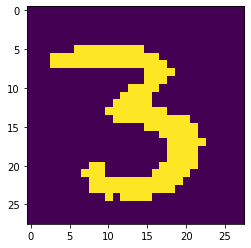

In [8]:
import matplotlib.pyplot as plt

plt.imshow(X_train[12].reshape(28,28))
plt.show()


In [9]:
class MRF_classifier(torch.nn.Module):
    def __init__(self, features_size, classes_size, y_classes): # featuresize=28*28, classesize=10
        super().__init__()
        self.features_size = features_size
        self.classes_size = classes_size
        self.y_classes = y_classes
        print(self.classes_size)
        print(self.features_size[0])
        print(self.features_size[1])
        self.param_unary = torch.nn.Parameter(torch.ones((self.classes_size,self.features_size[0]*self.features_size[1])).to(device=device)*10)
        self.param_pairwise = torch.nn.Parameter(torch.ones((self.classes_size,self.features_size[0]*self.features_size[1]*4)).to(device=device)*10)
        self.param_neighbour_coeff = torch.nn.Parameter(torch.tensor([0.5]).to(device=device))
#         print("\n[wjl] during initialization, param_unary is {}, param pairwise is {}".format(self.param_unary, self.param_pairwise))
        self.overall_neighbours, self.pairwise_neighbouts = self.get_all_neighbouts()
        
    def add_params(self, param_unary, param_pairwise):
        self.param_unary = param_unary
        self.param_pairwise = param_pairwise
        
    def get_feature_vector(self, i, j):
        result = [] # top, down, left, right, for any pixels at the edge, we use pixel 0 as its neighbour, so it's easier to code. Normally pixel 0 is black(0)
        if i > 0:
            result.append((i-1)*self.features_size[0]+ j)
        else:
            result.append(0)
        if i < self.features_size[0]-1:
            result.append((i+1)*self.features_size[0]+ j)
        else:
            result.append(0)
        if j > 0:
            result.append(i*self.features_size[0] + j-1)
        else:
            result.append(0)
        if j < self.features_size[1]-1:
            result.append(i*self.features_size[0] + j+1)
        else:
            result.append(0)
        return torch.as_tensor(result).to(device=device).to(torch.int64)

    def get_all_neighbouts(self):
        overall_neighbours = [] # shape should be 784 of tensor size 4 - this is the index of neighbours
        pairwise_neighbouts = [] # shape should be 784 of tensor size 4 - this is the index for those pairwise potentials
        for i in range(self.features_size[0]):
            for j in range(self.features_size[1]):
                overall_neighbours.append(self.get_feature_vector(i,j))
                pairwise_neighbouts.append(torch.arange(i*self.features_size[0]+j, i*self.features_size[0]+j+4))
        overall_neighbours = torch.stack(overall_neighbours).to(device=device).to(torch.int64)
        pairwise_neighbouts = torch.stack(pairwise_neighbouts).to(device=device).to(torch.int64)
        
        # print("--overall neighbout shape---:\n{}".format(overall_neighbours))
        # print("--pairwise_neighbouts shape---:\n{}".format(pairwise_neighbouts))
        return overall_neighbours, pairwise_neighbouts
        
    
    def straight_through_estimator(self, x): 
        x_hard = torch.zeros_like(x)
        x_hard[x>=0.5] = 1
        x = x_hard + x - x.detach()
        return x
        
    def forward(self, X):
        y_likelihood_all = self.predict_likelihood(X)
        softmax = torch.nn.Softmax(dim=0)
        softmax_all = softmax(y_likelihood_all)
        return softmax_all.T

    def predict(self, X):
        y_likelihood_all = self.predict_likelihood(X)
        softmax = torch.nn.Softmax(dim=0)
        softmax_all = softmax(y_likelihood_all)

        softmax_all_index = torch.argmax(softmax_all, axis=0)
        softmax_all_index = softmax_all_index.cpu().detach().numpy() 
        result = self.y_classes[softmax_all_index]
        # result = result.cpu().data.numpy()
        return result
    
    def predict_likelihood(self, X):
        X = X.reshape(X.shape[0], -1)
        X = self.straight_through_estimator(X)
        
        likelihood_all = torch.empty((self.y_classes.shape[0], X.shape[0])).to(device=device)
        for i in range(self.y_classes.shape[0]):
            
            a = X*torch.abs(self.param_unary[i]).to(torch.float64)
            b = torch.empty((X.shape[0],X.shape[1],4)).to(device=device).to(torch.float64)
            # b: for each x, each pixel, we first get their neighbour pixel value
            # expect shape:  X.shape[0]*784(number of pixels)*4(neighbours)
            for z in range(X.shape[0]):
              b[z] = torch.take(X[z], self.overall_neighbours) # expect X*784(number of pixels)*4(neighbours)

            neighbours_y = torch.empty((X.shape[0],X.shape[1],4)).to(device=device).to(torch.float64)
            # neighbours_y: for each x, each pixel, get the relationship of its neighbours & y value
            # expect shape:  X.shape[0]*784(number of pixels)*4(neighbours)
            for z in range(X.shape[0]):
              neighbours_y[z] = torch.take(torch.abs(self.param_unary[i]), self.overall_neighbours) # expect X*784(number of pixels)*4(neighbours)
            # neighbours_y_sum: sum along last axis (the axis where size=4) so we get unary potential for each pixel's neighbours, and times a conefficient
            neighbours_y_sum = self.param_neighbour_coeff*torch.sum(neighbours_y*b, axis=-1).reshape(X.shape[0], -1).to(torch.float64)
            
            c = torch.empty((X.shape[0],X.shape[1],4)).to(device=device).to(torch.float64)
            # c: for each x, each pixel, get the pairwise relationtship between pixel and its neighbour pixels.
            # expect shape:  X.shape[0]*784(number of pixels)*4(neighbours)
            for z in range(X.shape[0]):
                c[z] = torch.take(torch.abs(self.param_pairwise[i]), self.pairwise_neighbouts) # expect X*784(number of pixels)*4(neighbours)

            # d:  b (neighbour pixel value) * c (pariwise parameter) = pairwise potential
            # expect shape:  X.shape[0]*784(number of pixels)*4(neighbours)
            d = b*c
            
            # e: sum along last axis (the axis where size=4) so we get pairwise potential for each x, each pixel
            # expect shape:  X.shape[0]*784(number of pixels)
            e = torch.sum(d, axis=-1).reshape(X.shape[0], -1).to(torch.float64)
            
            # f: then we sum the pixel's unary + pixel's pairwise + pixel's neighbours's unary potential, and sum along the last axis (size=784)
            # expect shape:  X.shape[0]
            f =  torch.sum(a+e+neighbours_y_sum, axis=-1).to(torch.float64)

            likelihood_all[i] = f
        
        # get Z: normalziation term.
        # expect shape:  10
        Z = torch.sum(likelihood_all, -1)
        # print("here the Z shape is {}".format(Z.shape))
        for j in range(self.y_classes.shape[0]):
            likelihood_all[j] -= torch.log(Z[j])
        
        return likelihood_all
    

model = MRF_classifier([28,28], 10, y_classes).to(device)
print(model) # expecting NaiveBayes()
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

10
28
28
MRF_classifier()
Layer: param_unary | Size: torch.Size([10, 784]) | Values : tensor([[10., 10., 10.,  ..., 10., 10., 10.],
        [10., 10., 10.,  ..., 10., 10., 10.]], device='cuda:0',
       grad_fn=<SliceBackward>) 

Layer: param_pairwise | Size: torch.Size([10, 3136]) | Values : tensor([[10., 10., 10.,  ..., 10., 10., 10.],
        [10., 10., 10.,  ..., 10., 10., 10.]], device='cuda:0',
       grad_fn=<SliceBackward>) 

Layer: param_neighbour_coeff | Size: torch.Size([1]) | Values : tensor([0.5000], device='cuda:0', grad_fn=<SliceBackward>) 



In [10]:
y_train_torch_one_hot = torch.nn.functional.one_hot(y_train_torch.to(device=device).to(torch.int64))
print("y_train torch is {}".format(y_train_torch_one_hot))
print(y_train_torch_one_hot.shape)

y_train torch is tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0')
torch.Size([600, 10])


In [11]:
class CategoricalCrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(CategoricalCrossEntropyLoss, self).__init__()

    def forward(self, y_hat, y):
        return torch.nn.NLLLoss()(y_hat, torch.argmax(y, dim=1))
#         return torch.nn.NLLLoss()(torch.log(y_hat), torch.argmax(y, dim=1))

10
28
28
odict_keys(['param_unary', 'param_pairwise', 'param_neighbour_coeff'])
odict_keys(['param_unary', 'param_pairwise', 'param_neighbour_coeff'])
odict_keys(['param_unary', 'param_pairwise', 'param_neighbour_coeff'])
odict_keys(['param_unary', 'param_pairwise', 'param_neighbour_coeff'])
odict_keys(['param_unary', 'param_pairwise', 'param_neighbour_coeff'])
odict_keys(['param_unary', 'param_pairwise', 'param_neighbour_coeff'])
odict_keys(['param_unary', 'param_pairwise', 'param_neighbour_coeff'])
odict_keys(['param_unary', 'param_pairwise', 'param_neighbour_coeff'])
odict_keys(['param_unary', 'param_pairwise', 'param_neighbour_coeff'])
odict_keys(['param_unary', 'param_pairwise', 'param_neighbour_coeff'])
odict_keys(['param_unary', 'param_pairwise', 'param_neighbour_coeff'])
odict_keys(['param_unary', 'param_pairwise', 'param_neighbour_coeff'])
odict_keys(['param_unary', 'param_pairwise', 'param_neighbour_coeff'])
odict_keys(['param_unary', 'param_pairwise', 'param_neighbour_coeff'

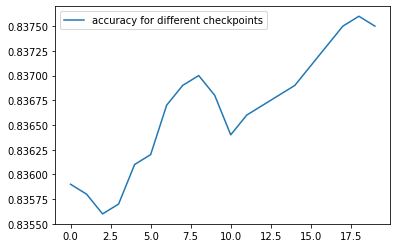

In [ ]:
# this is just to plot the accuracy over different epoch
accuracy_list = []
model = MRF_classifier([28,28], 10, y_classes).to(device)
for checkpoint in range(1000,1100, 5):
    # last_checkpoint = 55
    model_previous_name = 'checkpoint_{}.pth'.format(checkpoint-1)
    path = F"/content/gdrive/My Drive/my_cs5340/checkpoints3-abs/{model_previous_name}" 
    state_dict = torch.load(path)
    print(state_dict.keys())
    model.load_state_dict(state_dict)
    y_pred = model.predict(X_test_torch)
    
    y_test_copy = y_test_torch.cpu().detach().numpy()
    acc = np.sum(y_pred==y_test_copy)/y_test_copy.shape[0]
    accuracy_list.append(acc)

plt.plot(accuracy_list, label='accuracy for different checkpoints')
plt.legend()
plt.show()

In [ ]:
highest_idx= -1
highest_val = -1
j = 0
for i in accuracy_list:
  j+=1
  if i > highest_val:
    highest_idx = j
    highest_val = i
print("when epoch number = {}, the accuracy is highest: {}".format(highest_idx*5+1000, highest_val))

when epoch number = 1095, the accuracy is highest: 0.8376


In [12]:
# this is for the optimizr
lrs = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr = lrs)
criterion = CategoricalCrossEntropyLoss()#torch.nn.NLLLoss()
loss_dict = []

num_epochs = 1200
for epoch in range(1100, num_epochs):
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch_one_hot)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_dict.append(loss.item())
    if (epoch+1) % 5 == 0:
      print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
      torch.save(model.state_dict(), '/content/gdrive/My Drive/my_cs5340/checkpoints3-abs/checkpoint_{}.pth'.format(epoch))


KeyboardInterrupt: ignored

In [13]:
model_previous_name = 'checkpoint_{}.pth'.format(1094)
path = F"/content/gdrive/My Drive/my_cs5340/checkpoints3-abs/{model_previous_name}" 
state_dict = torch.load(path)
print(state_dict.keys())
model.load_state_dict(state_dict)
y_pred = model.predict(X_test_torch)

y_test_copy = y_test_torch.cpu().detach().numpy()
acc = np.sum(y_pred==y_test_copy)/y_test_copy.shape[0]
print(acc)

odict_keys(['param_unary', 'param_pairwise', 'param_neighbour_coeff'])
0.8375


In [14]:
!pip3 install foolbox

     |████████████████████████████████| 1.7MB 16.8MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 163kB 57.2MB/s 
     |████████████████████████████████| 71kB 9.8MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [15]:
import foolbox as fb
from foolbox import PyTorchModel, accuracy, samples, plot, criteria, distances
import foolbox.attacks as fa
import matplotlib.pyplot as plt
import time
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

First try the attack script we used in the very beginning.

In [ ]:
# def plot_images(images):
#     fig, axs = plt.subplots(1, len(images), figsize=(24, 24))

#     for i, ax in enumerate(axs.flat):
#         image = images[i]
#         image = np.squeeze(image, axis=0)
#         ax.matshow(image)
#         ax.axis('off')
#         ax.set_title(f'Image {i}')

In [ ]:
# # save the model maybe
# mymodel = model.eval()
# fmodel = PyTorchModel(mymodel, bounds=(0, 1))
# batch_size = 20
# images, labels = samples(fmodel, dataset="mnist", batchsize=batch_size)

# clean_acc = accuracy(fmodel, images, labels)
# predictions = fmodel(images).argmax(-1)
# # plot_images(images.cpu().numpy())
# print("labels     : ", [l for l in labels.cpu().numpy()])
# print("predictions: ", [l for l in predictions.cpu().numpy()])

# print(f"clean accuracy:  {clean_acc * 100:.1f} %")

labels     :  [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]
predictions:  [7, 2, 1, 0, 4, 1, 4, 9, 2, 9, 0, 8, 9, 0, 1, 5, 7, 7, 3, 4]
clean accuracy:  85.0 %


epsilons
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.85 0.85 0.85 0.85 0.85 0.85 0.85]
Time taken:  0.11526505947113037 seconds
Clipped adversaries: 


{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.85 0.65 0.55 0.5  0.45 0.   0.  ]
Time taken:  0.11073719263076783 seconds
Clipped adversaries: 


{'name': 'Additive Uniform Noise Attack', 'model': LinfAdditiveUniformNoiseAttack()}
   [0.85 0.85 0.85 0.85 0.85 0.9  0.75]
Time taken:  0.013724076747894286 seconds
Clipped adversaries: 


{'name': 'Additive Gaussian Noise Attack', 'model': L2AdditiveGaussianNoiseAttack()}
   [0.85 0.85 0.85 0.85 0.85 0.85 0.85]
Time taken:  0.013532006740570068 seconds
Clipped adversaries: 


{'name': 'Linear Search Contrast Reduction Attack', 'model': LinearSearchContrastReductionAttac

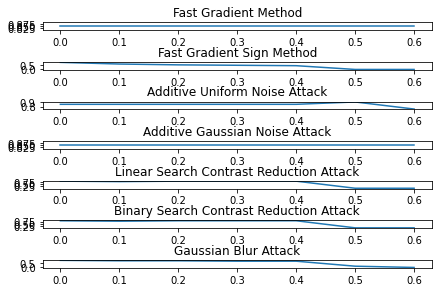

In [ ]:
# %matplotlib inline

# attacks = [
#            # gradient-based attacks
#            {"name": "Fast Gradient Method", "model": fa.L2FastGradientAttack()},
#            {"name": "Fast Gradient Sign Method", "model": fa.LinfFastGradientAttack()},
#           #  {"name": "L2 Projected Gradient Descent", "model": fa.L2ProjectedGradientDescentAttack()},
#           #  {"name": "Linf Projected Gradient Descent", "model": fa.LinfProjectedGradientDescentAttack()},
#           #  {"name": "Carlini & Wagner L2 Attack", "model": fa.L2CarliniWagnerAttack()},

#         # decision-based attacks
# #            {"name": "Boundary Attack", "model": fa.BoundaryAttack()},
#            {"name": "Additive Uniform Noise Attack", "model": fa.LinfAdditiveUniformNoiseAttack()},
#            {"name": "Additive Gaussian Noise Attack", "model": fa.L2AdditiveGaussianNoiseAttack()},
#            {"name": "Linear Search Contrast Reduction Attack", "model": fa.LinearSearchContrastReductionAttack(distance=distances.linf)},
#            {"name": "Binary Search Contrast Reduction Attack", "model": fa.BinarySearchContrastReductionAttack(distance=distances.linf)},
#            {"name": "Gaussian Blur Attack", "model": fa.GaussianBlurAttack(distance=distances.linf)},
# ]
    
# epsilons = [
#         0.0,
# #         0.0005,
# #         0.001,
# #         0.0015,
# #         0.002,
# #         0.003,
# #         0.005,
# #         0.01,
# #         0.02,
# #         0.03,
#         0.1,
#         0.2,
#         0.3,
#         0.4,
#         0.5,
#         0.6,
# #         0.7,
# #         0.8,
# #         0.9,
# #         1.0,
#     ]
# print("epsilons")
# print(epsilons)
# print("")

# attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=bool)
# fig, axs = plt.subplots(len(attacks))
# fig.tight_layout()
# for i, attack in enumerate(attacks):
#     # plot_images(images.cpu().numpy())
#     # The raw adversarial examples. This depends on the attack and we cannot make an guarantees about this output.
#     # The clipped adversarial examples. These are guaranteed to not be perturbed more than epsilon and thus are the actual adversarial examples you want to visualize. Note that some of them might not actually switch the class. To know which samples are actually adversarial, you should look at the third tensor.
#     # The third tensor contains a boolean for each sample, indicating which samples are true adversarials that are both misclassified and within the epsilon balls around the clean samples.
#     t1 = time.time()
#     raw_adv, clipped_adv, is_adv = attack["model"](fmodel, images, labels, epsilons=epsilons)
#     t2 = time.time()
#     success_ = is_adv.cpu().numpy()
#     attack_success[i] = success_
#     print(attack)
#     print("  ", 1.0 - success_.mean(axis=-1).round(2))
#     print("Time taken: ", (t2 - t1) / batch_size, "seconds")

#     # plot the robust accuracy against epsilons for the particular attack
#     robust_accuracy = 1 - is_adv.float().mean(axis=-1)
#     axs[i].plot(epsilons, robust_accuracy.cpu().numpy())
#     axs[i].set_title(attack["name"])
#     # axs.plot(epsilons, robust_accuracy.cpu().numpy())
#     # axs.set_title(attack["name"])

#     print("Clipped adversaries: \n\n")
#     # plot_images(clipped_adv[0].cpu().numpy())


Then let's try the latest attack script.

In [16]:
model = model.cuda()
model.eval()
fmodel = fb.PyTorchModel(model, bounds=(0, 1))

test_size = 1000  # assuming we are running 1000 tests for each attack
batch_size = 20   # adjust your batch size according to memory limitation, as long as it's a divisor of 1000
num_batch = int(test_size / batch_size)

test_dataset = MNIST(root='./data', download=True, train=False, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False), 'epsilons': [1, 2, 3, 4, 5]}
Clean accuracy: 0.80900
Average time taken for each test: 0.07497137928009033 seconds
Accuracy with Fast Gradient Method attack: tensor([0.7320, 0.6190, 0.4410, 0.1750, 0.0330])


{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False), 'epsilons': [0.1, 0.2, 0.3, 0.4, 0.5]}
Clean accuracy: 0.80900
Average time taken for each test: 0.07425941371917724 seconds
Accuracy with Fast Gradient Sign Method attack: tensor([0.6880, 0.5560, 0.3870, 0.2290, 0.0070])


{'name': 'Additive Uniform Noise Attack', 'model': LinfAdditiveUniformNoiseAttack(), 'epsilons': [0.1, 0.2, 0.3, 0.4, 0.5]}
Clean accuracy: 0.80900
Average time taken for each test: 0.010834023237228393 seconds
Accuracy with Additive Uniform Noise Attack attack: tensor([0.7960, 0.8130, 0.8040, 0.809

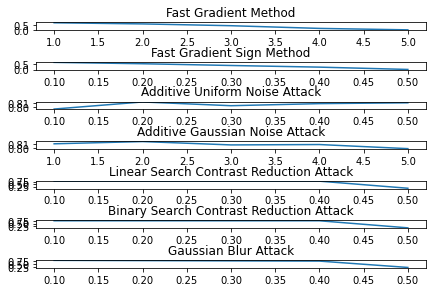

In [ ]:
%matplotlib inline


Linf_epsilons = [
    0.1,
    0.2,
    0.3,
    0.4,
    0.5
]
CW_epsilons = [
    0.1,
    1,
    10,
    100,
    1000
]
L2_epsilons = [
    1,
    2,
    3,
    4,
    5
]
attacks = [
    # gradient-based attacks
    {"name": "Fast Gradient Method", "model": fa.L2FastGradientAttack(), "epsilons": L2_epsilons},
    {"name": "Fast Gradient Sign Method", "model": fa.LinfFastGradientAttack(), "epsilons": Linf_epsilons},
    # {"name": "L2 Projected Gradient Descent", "model": fa.L2ProjectedGradientDescentAttack(), "epsilons": L2_epsilons},
    # {"name": "Linf Projected Gradient Descent", "model": fa.LinfProjectedGradientDescentAttack(), "epsilons": Linf_epsilons},
    # run CW later because it takes a lont time
    # {"name": "Carlini & Wagner L2 Attack", "model": fa.L2CarliniWagnerAttack(), "epsilons": CW_epsilons},
    # # decision-based attacks
    # {"name": "Boundary Attack", "model": fa.BoundaryAttack(), "epsilons": L2_epsilons}, # ?
    {"name": "Additive Uniform Noise Attack", "model": fa.LinfAdditiveUniformNoiseAttack(), "epsilons": Linf_epsilons},
    {"name": "Additive Gaussian Noise Attack", "model": fa.L2AdditiveGaussianNoiseAttack(), "epsilons": L2_epsilons},
    {"name": "Linear Search Contrast Reduction Attack", "model": fa.LinearSearchContrastReductionAttack(distance=distances.linf), "epsilons": Linf_epsilons}, # ?
    {"name": "Binary Search Contrast Reduction Attack", "model": fa.BinarySearchContrastReductionAttack(distance=distances.linf), "epsilons": Linf_epsilons}, # ?
    {"name": "Gaussian Blur Attack", "model": fa.GaussianBlurAttack(distance=distances.linf), "epsilons": Linf_epsilons} # ?
]


fig, axs = plt.subplots(len(attacks))
fig.tight_layout()

for i, attack in enumerate(attacks):
    clean_accuracy = torch.zeros(num_batch)
    robust_accuracy_batch = torch.zeros([num_batch, len(L2_epsilons)])
    count = 0

    t1 = time.time()
    for images, labels in test_dataloader:
        if count == num_batch:
            break
        images = images.cuda()
        labels = labels.cuda()
        clean_accuracy[count] = fb.utils.accuracy(fmodel, images, labels)

        raw_adv, clipped_adv, is_adv = attack["model"](fmodel, images, labels, epsilons=attack["epsilons"])
        success_ = is_adv.cpu().numpy()
        robust_accuracy_batch[count] = torch.from_numpy(1.0 - success_.mean(axis=-1))

        count += 1

    t2 = time.time()
    print(attack)
    print("Clean accuracy: {:.5f}".format(torch.mean(clean_accuracy)))
    print("Average time taken for each test: {} seconds".format((t2 - t1) / test_size))
    robust_accuracy = torch.mean(robust_accuracy_batch, dim=0)
    print("Accuracy with {} attack: {}\n\n".format(attack["name"], robust_accuracy))

    axs[i].plot(attack["epsilons"], robust_accuracy.cpu().numpy())
    axs[i].set_title(attack["name"])


